In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms


import numpy as np
import matplotlib.pyplot as plt
import scipy
from PIL import Image

from google.colab import runtime


In [2]:
#Hyperparameters
lr = 0.01 #Drop this down, too high
momentum = 0 #default = 0
weight_decay = 0 #default = 0
dampening = 0 #default = 0

#Other
batch_size = 64
epochs = 100

In [3]:
transforms = {
    'train':
    transforms.Compose( #Composing several transforms together
    [transforms.ToTensor(), #To tensor object
     transforms.RandomRotation(degrees=15),
     transforms.RandomHorizontalFlip(),
     transforms.ColorJitter(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #Mean = 0.5, std = 0.5
     transforms.Resize((256,256)) #Speeds up model without losing too much information
     ]),

    'val':
    transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((256,256))
     ]),

    'test':
    transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((256,256))
     ])
}

In [4]:
train_data = datasets.Flowers102(root='./data', split='train', transform=transforms['train'], download=True)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

100%|██████████| 344862509/344862509 [00:16<00:00, 21332892.59it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 880610.88it/s]


100%|██████████| 14989/14989 [00:00<00:00, 9358205.22it/s]


In [5]:
val_data = datasets.Flowers102(root='./data', split='val', transform=transforms['val'], download=False)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)


In [6]:
test_data = datasets.Flowers102(root='./data', split='test', transform=transforms['test'], download=False)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

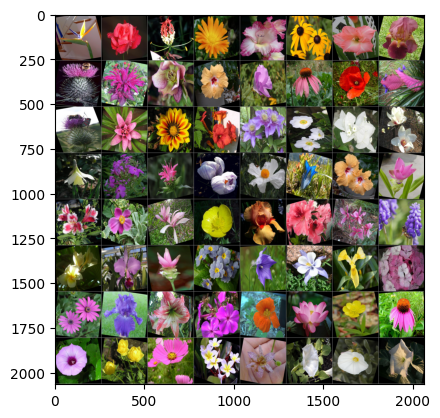

In [7]:
# Show the images in the batch to see what the transforms are doing to them
def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(train_dataloader)
for i in range(1):
  images, lbls = next(dataiter)
  imshow(torchvision.utils.make_grid(images))

In [8]:
#Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [9]:
class BasicNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*25*25, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 102)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [10]:
#Architecture inspired by https://poloclub.github.io/cnn-explainer/#article-input
#and PyTorch for Deep Learning & Machine Learning – Full Course by freeCodeCamp.org https://www.youtube.com/watch?v=V_xro1bcAuA
class CNNv1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    #Block is comprised of multiple layers
    self.conv_block_1 = nn.Sequential(
        #Conv layer to extract features
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3, #Size of the kernel it looks at
                  stride=1, #How far it steps between kernels
                  padding=1), #Added to the edges to stop the miage decreasing in size
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
         nn.ReLU(),
         nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*64*64,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    return x

In [11]:
class CNNv2(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    #Block is comprised of multiple layers
    self.conv_block_1 = nn.Sequential(
        #Conv layer to extract features
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3, #Size of the kernel it looks at
                  stride=1, #How far it steps between kernels
                  padding=1), #Added to the edges to stop the miage decreasing in size
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
         nn.ReLU(),
         nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*64*64,
                  out_features=output_shape),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    return x

In [12]:
model = CNNv1(input_shape=3,
              hidden_units=102,
              output_shape=102).to(device)
print(model)

CNNv1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(102, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(102, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(102, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=417792, out_features=102, bias=True)
  )
)


In [13]:
#Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=lr,
                            momentum=momentum,
                            weight_decay=weight_decay,
                            dampening=dampening)

In [14]:
#Train the model using the training data
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 4 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [15]:
#Train and val together
def trainValLoop(dataloaders, model, loss_fn, optimizer, epochs):
  #Keep track of accuracy and loss to use later
  test_acc_hist = []
  test_loss_hist = []
  train_acc_hist = []
  train_loss_hist = []

  #Save model here

  for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    #Go between training and testing every epoch
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.test()

      running_loss = 0.0
      running_corrects = 0

      for batch, (X, y) in enumerate(dataloaders[phase]):
        X, y = X.to(device), y.to(device)

        #Gradient enabled when training, disabled when testing
        with torch.set_grad_enabled(phase == 'train'):
          #Compute prediction error
          pred = model(X)
          loss = loss_fn(pred, y)

          if phase == 'train':
            #Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()




In [16]:
#Validate the models progress using the validation data
def validate(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [17]:
#Test the model on the test data
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
#Train-Validation loop
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    validate(val_dataloader, model, loss_fn)

#Test model
test(test_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 4.623986  [   64/ 1020]
loss: 4.642391  [  320/ 1020]
loss: 4.646887  [  576/ 1020]
loss: 4.641133  [  832/ 1020]
Validation Error: 
 Accuracy: 1.5%, Avg loss: 4.617618 

Epoch 2
-------------------------------
loss: 4.612805  [   64/ 1020]
loss: 4.618880  [  320/ 1020]
loss: 4.640769  [  576/ 1020]
loss: 4.626743  [  832/ 1020]
Validation Error: 
 Accuracy: 1.9%, Avg loss: 4.608076 

Epoch 3
-------------------------------
loss: 4.600892  [   64/ 1020]
loss: 4.608946  [  320/ 1020]
loss: 4.603117  [  576/ 1020]
loss: 4.605294  [  832/ 1020]
Validation Error: 
 Accuracy: 3.4%, Avg loss: 4.588293 

Epoch 4
-------------------------------
loss: 4.585029  [   64/ 1020]
loss: 4.556961  [  320/ 1020]
loss: 4.573478  [  576/ 1020]
loss: 4.569156  [  832/ 1020]
Validation Error: 
 Accuracy: 3.4%, Avg loss: 4.539489 

Epoch 5
-------------------------------
loss: 4.533696  [   64/ 1020]
loss: 4.519587  [  320/ 1020]
loss: 4.544264  [  576/ 1020]
lo

In [ ]:
#Stops Google stealing my credits
runtime.unassign()